In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

--2021-08-30 10:35:23--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.80.224.107, 2a02:26f0:e3:3af::e59, 2a02:26f0:e3:39c::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.80.224.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip.1’

kagglecatsanddogs_3 100%[===================>] 786.68M   137MB/s    in 5.7s    

2021-08-30 10:35:28 (139 MB/s) - ‘kagglecatsanddogs_3367a.zip.1’ saved [824894548/824894548]



In [ ]:
!unzip -q "/content/kagglecatsanddogs_3367a.zip"

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls "PetImages/"

In [ ]:
## Importing necessary libraries for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
from tqdm import tqdm

In [ ]:
# Number of Dogs Images
len(os.listdir("PetImages/Dog"))

12501

In [ ]:
# Number of Cats Images
len(os.listdir("PetImages/Cat"))

12501

In [ ]:
DataPath = pathlib.Path("PetImages")
all_paths = DataPath.glob("*/*.jpg")
all_paths

<generator object Path.glob at 0x7f7ea2eb58d0>

In [ ]:
all_paths = list(all_paths)
all_paths[:5]

[PosixPath('PetImages/Cat/11361.jpg'),
 PosixPath('PetImages/Cat/151.jpg'),
 PosixPath('PetImages/Cat/9805.jpg'),
 PosixPath('PetImages/Cat/5493.jpg'),
 PosixPath('PetImages/Cat/6971.jpg')]

In [ ]:
all_paths = list(map(lambda x: str(x), all_paths))
all_paths[:5]

['PetImages/Cat/11361.jpg',
 'PetImages/Cat/151.jpg',
 'PetImages/Cat/9805.jpg',
 'PetImages/Cat/5493.jpg',
 'PetImages/Cat/6971.jpg']

In [ ]:
from random import shuffle

In [ ]:
shuffle(all_paths)
all_paths[:10]

['PetImages/Cat/2923.jpg',
 'PetImages/Dog/2450.jpg',
 'PetImages/Cat/9540.jpg',
 'PetImages/Dog/10026.jpg',
 'PetImages/Dog/8983.jpg',
 'PetImages/Cat/961.jpg',
 'PetImages/Dog/8244.jpg',
 'PetImages/Cat/7027.jpg',
 'PetImages/Cat/7374.jpg',
 'PetImages/Cat/5996.jpg']

In [ ]:
def testImageQuality(paths):
  new_paths = []

  for path in tqdm(paths):
    try:
      image = tf.io.read_file(path)
      image = tf.io.decode_jpeg(image, channels=3)
    except:
      continue
    new_paths.append(path)
  return new_paths

In [ ]:
all_paths = testImageQuality(all_paths)
all_paths[:10]

100%|██████████| 25000/25000 [00:40<00:00, 612.38it/s]


['PetImages/Cat/2923.jpg',
 'PetImages/Dog/2450.jpg',
 'PetImages/Cat/9540.jpg',
 'PetImages/Dog/10026.jpg',
 'PetImages/Dog/8983.jpg',
 'PetImages/Cat/961.jpg',
 'PetImages/Dog/8244.jpg',
 'PetImages/Cat/7027.jpg',
 'PetImages/Cat/7374.jpg',
 'PetImages/Cat/5996.jpg']

In [ ]:
# Getting their respective labels
def get_label(image_path):
  return image_path.split("/")[-2]

In [ ]:
all_labels = list(map(lambda x: get_label(x), all_paths))
all_labels[:10]

['Cat', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Cat', 'Cat']

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
Le = LabelEncoder()
all_labels = Le.fit_transform(all_labels)

all_labels[:10]

array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_paths, val_paths, train_labels, val_labels = train_test_split(all_paths, all_labels)

In [ ]:
train_paths[:10], train_labels[:10]

(['PetImages/Dog/4253.jpg',
  'PetImages/Dog/1862.jpg',
  'PetImages/Dog/11492.jpg',
  'PetImages/Dog/6358.jpg',
  'PetImages/Cat/5587.jpg',
  'PetImages/Dog/1887.jpg',
  'PetImages/Dog/10235.jpg',
  'PetImages/Cat/10598.jpg',
  'PetImages/Dog/6610.jpg',
  'PetImages/Dog/3339.jpg'],
 array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1]))

In [ ]:
len(train_paths)

18618

In [ ]:
# Function used to decode jpeg into Tensor

def load(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels=3) # we are getting here the image tensor
  return image, label

In [ ]:
# Define Image size and batch size
img_size = 224
batch_size = 128

# Basic transformation 
resize = tf.keras.Sequential([
         tf.keras.layers.experimental.preprocessing.Resizing(img_size, img_size)
])

# Data augmentation 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, -0.2))
])

In [ ]:
# Function used to create a Tensorflow data object
autotune = tf.data.experimental.AUTOTUNE

def get_dataset(paths, labels, train=True):
  image_paths = tf.convert_to_tensor(paths)
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  labels_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))

  dataset = dataset.map(lambda image, label: load(image, label))
  dataset = dataset.map(lambda image, label: (resize(image), label), num_parallel_calls=autotune)
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(batch_size)

  if train:
    dataset = dataset.map(lambda image, label: (data_augmentation(image), label), num_parallel_calls=autotune)
    dataset = dataset.repeat()

  return dataset

In [ ]:
# Creating train dataset object and verifying it
%time train_dataset = get_dataset(train_paths, train_labels)

image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 462 ms, sys: 14.9 ms, total: 477 ms
Wall time: 475 ms
(128, 224, 224, 3)
(128,)


In [ ]:
train_dataset

<RepeatDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

Dog


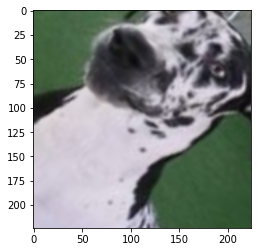

In [ ]:
# View a sample training image
print(Le.inverse_transform(label)[1])
plt.imshow((image[1].numpy()/255).reshape(224, 224, 3))

In [ ]:
# Creating validation dataset object and verifying it
%time val_dataset = get_dataset(val_paths, val_labels, train=False)

image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 28.6 ms, sys: 2.96 ms, total: 31.6 ms
Wall time: 33.7 ms
(128, 224, 224, 3)
(128,)


Dog


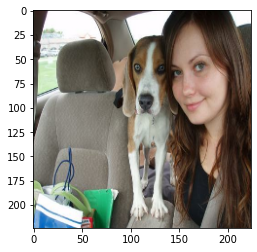

In [ ]:
print(Le.inverse_transform(label)[1])
plt.imshow((image[1].numpy()/255).reshape(224, 224, 3))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalMaxPool2D

In [ ]:
model = Sequential()

In [ ]:
#Block 1 
model.add(Conv2D(input_shape=(224, 224, 3), padding="same", filters=32, kernel_size=(7,7)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Block 2
model.add(Conv2D(padding="valid", filters=64, kernel_size=(5,5)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Block 3
model.add(Conv2D(padding="valid", filters=128, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Block 2
model.add(Conv2D(padding="valid", filters=256, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(GlobalMaxPool2D())

model.add(Dense(units=256))
model.add(Activation("relu"))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation("sigmoid"))

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      4736      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 64)      51264     
_________________________________________________________________
activation_1 (Activation)    (None, 108, 108, 64)     

In [ ]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

In [ ]:
# Training the model
history = model.fit(
    train_dataset,
    steps_per_epoch = len(train_paths)//batch_size,
    epochs = 10,
    validation_data = val_dataset,
    validation_steps = len(val_paths)//batch_size,
)

Epoch 1/10
145/145 [==============================] - 220s 1s/step - loss: 0.9490 - accuracy: 0.5705 - val_loss: 0.6312 - val_accuracy: 0.6514
Epoch 2/10
145/145 [==============================] - 210s 1s/step - loss: 0.6161 - accuracy: 0.6608 - val_loss: 0.6864 - val_accuracy: 0.5360
Epoch 3/10
145/145 [==============================] - 210s 1s/step - loss: 0.5811 - accuracy: 0.6956 - val_loss: 0.8322 - val_accuracy: 0.5106
Epoch 4/10
145/145 [==============================] - 207s 1s/step - loss: 0.5639 - accuracy: 0.7075 - val_loss: 0.6507 - val_accuracy: 0.6094
Epoch 5/10
145/145 [==============================] - 209s 1s/step - loss: 0.5530 - accuracy: 0.7176 - val_loss: 0.8074 - val_accuracy: 0.5153
Epoch 6/10
145/145 [==============================] - 208s 1s/step - loss: 0.5279 - accuracy: 0.7377 - val_loss: 0.7779 - val_accuracy: 0.5306
Epoch 7/10
145/145 [==============================] - 210s 1s/step - loss: 0.5144 - accuracy: 0.7442 - val_loss: 0.5998 - val_accuracy: 0.6366

In [ ]:
# Evaluating the model
loss, acc = model.evaluate(val_dataset)

print("Testing Acc : ", acc)
print("Testing Loss : ", loss)

49/49 [==============================] - 20s 379ms/step - loss: 0.5914 - accuracy: 0.6584
Testing Acc :  0.6583951115608215
Testing Loss :  0.5913687944412231
